<a href="https://colab.research.google.com/github/likithavummiti/LIKITHA-FMML-LABS/blob/main/FMML_Module_9_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 3**
### Module coordinator: Kushagra Agarwal

## 1. Understanding Convolutions

<img src="https://miro.medium.com/max/464/0*e-SMFTzO8r7skkpc" width=650px/>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Importing some pytorch packages
import torch
from torch.nn import Conv2d

Central to CNNs, a convolution operation is a linear element-wise multiplication operation between a small filter/kernel and same-sized patch from the image. We move this filter over the image like a sliding window from top left to bottom right. For each point on the image, a value is calculated based on the filter using a convolution operation. These filters can do simplest task like checking if there is a vertical line in the image or complicated task like detecting a human eye in the image.

Let's look at the convolution formula:

Convolution between image
$f(x, y)$ and kernel $k(x, y)$ is
$$f(x,y) * k(x,y) = \sum \limits _{i=0} ^{W-1} \sum \limits _{j=0} ^{H-1} f(i, j) k(x − i, y − j)$$

where $W$ and $H$ are the the width and height of the image.

The code demonstrates the convolution operation of a 2D matrix (image) with various filters

<img src="https://www.researchgate.net/profile/Chaim-Baskin/publication/318849314/figure/fig1/AS:614287726870532@1523469015098/Image-convolution-with-an-input-image-of-size-7-7-and-a-filter-kernel-of-size-3-3.png" alt="Convolution" width=650px height=280px/>

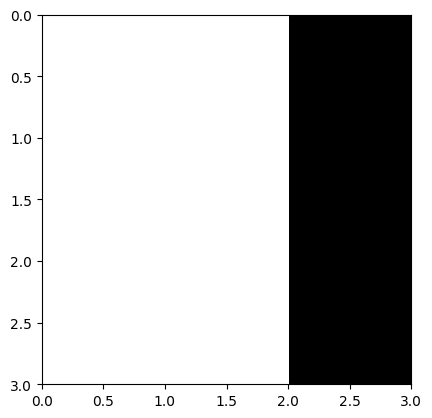

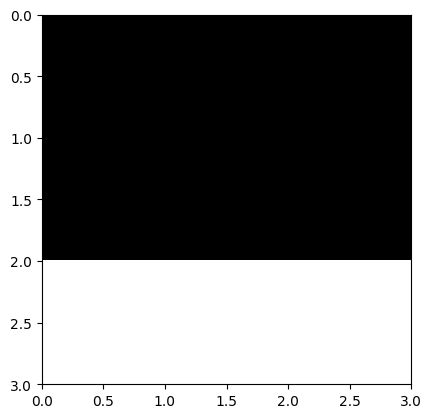

In [3]:
# 2D 3x3 binary image with vertical edge
image1 = np.array([[1,1,0], [1,1,0], [1,1,0]])

# 2D 3x3 binary image with horizontal edge
image2 = np.array([[0,0,0], [0,0,0], [1,1,1]])

# On plotting the images
plt.imshow(image1, cmap='gray', extent=[0, 3, 3, 0])
plt.show()
plt.imshow(image2, cmap='gray', extent=[0, 3, 3, 0])
plt.show()

In [4]:
# Vertical Line filter
filter = np.array([[1,0,-1],
                   [1,0,-1],
                   [1,0,-1]])

# Applying filter to first image
output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

# Applying filter to second image
output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)

Output from first image:  3
Output from second image:  0


In [5]:
# Horizontal edge filter
filter = np.array([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]])

output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)

Output from first image:  0
Output from second image:  3


Non-zero output suggests that there is a vertical edge present in the first image and not present in the second image. Similarly, horizontal edge is detected in second.

Let's define a function to use convolution layer from Pytorch and use our own kernel to detect edges in image

In [6]:
def apply_conv(image, kernel, padding=0, stride=1):

  #--------IMAGE PREPROCESSING-------
  image = torch.from_numpy(image)
  # Pytorch requires input to convolution in (N,C,H,W), where N = batch size and C=#channels in input
  input = image.view((1,1,image.shape[0], image.shape[1]))

  # --------------KERNEL-------------
  kernel = torch.from_numpy(kernel.astype(np.float32))

  # Pytorch requires kernel of shape (N,C,H,W), where N = batch size and C=#channels in input
  kernel = kernel.view((1,1,kernel.shape[0], kernel.shape[1]))

  # ---------CONVOLUTION LAYER from Pytorch--------
  conv = Conv2d(in_channels=1, out_channels=1, kernel_size=kernel.shape, padding=padding, stride=stride)

  # Set the kernel weights in the convolution layer
  conv.weight = torch.nn.Parameter(kernel)

  # ---------APPLY CONVOLUTION--------
  output = conv(input.float())
  output_img = output.data.numpy()  # Tensor to back in numpy
  output_img = output_img.reshape((-1, output_img.shape[-1])) # Reshape to 2D image

  return output_img

In [9]:
import numpy as np
import torch

def apply_conv(image, kernel, padding=0, stride=1):
    # Check if the image is None or not
    if image is None:
        raise ValueError("Input image is None. Please provide a valid image.")

    #--------IMAGE PREPROCESSING-------
    image = torch.from_numpy(image)
    # Pytorch requires input to convolution in (N,C,H,W), where N = batch size and C=#channels in input
    input = image.view((1,1,image.shape[0], image.shape[1]))

    #--------KERNEL PREPROCESSING--------
    # Pytorch requires kernel in (C_out, C_in, H, W)
    kernel = torch.from_numpy(kernel)
    kernel = kernel.view(1,1,kernel.shape[0], kernel.shape[1])

    # Convolution
    conv = torch.nn.Conv2d(1, 1, kernel_size=kernel.shape[2:], padding=padding, stride=stride)
    conv.weight.data = kernel.float()
    out = conv(input.float())
    return out.detach().numpy().squeeze()

# Example usage:
image = np.array([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]])

filter = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]])

out1 = apply_conv(image, filter, padding=0, stride=1)
print(out1)


-5.888481


In [12]:
import matplotlib.pyplot as plt

# Check if out1 is empty or not
if out1.size == 0:
    print("Output array is empty. Cannot visualize.")
else:
    # Check the shape of out1
    if len(out1.shape) == 4:
        # Calculate the mean across channels to convert the output to grayscale
        out1_gray = out1.mean(axis=1)  # Assuming the channel dimension is axis 1

        # Plot the grayscale output
        plt.imshow(out1_gray[0], cmap='gray')  # Assuming out1 has a batch dimension of size 1
        plt.title('Horizontal edge')
        plt.show()
    else:
        print("Output array has unexpected shape. Cannot visualize.")


Output array has unexpected shape. Cannot visualize.


## Pooling Layers

Pooling layers are used to reduce the dimensions of the feature maps. Thus, it reduces the number of parameters to learn and the amount of computation performed in the network. The pooling layer summarises the features present in a region of the feature map generated by a convolution layer.

1) Max Pooling:

<img src='https://media.geeksforgeeks.org/wp-content/uploads/20190721025744/Screenshot-2019-07-21-at-2.57.13-AM.png' height=150px/>

2) Average Pooling:

<img src='https://media.geeksforgeeks.org/wp-content/uploads/20190721030705/Screenshot-2019-07-21-at-3.05.56-AM.png' height=150px/>

## Softmax layer/activation
Recall that logistic regression produces a decimal between 0 and 1.0. For example, a logistic regression output of 0.8 from an email classifier suggests an 80% chance of an email being spam and a 20% chance of it being not spam. Clearly, the sum of the probabilities of an email being either spam or not spam is 1.0.

Softmax extends this idea into a multi-class world. That is, Softmax assigns decimal probabilities to each class in a multi-class problem. Those decimal probabilities must add up to 1.0. This additional constraint helps training converge more quickly than it otherwise would.
Softmax is implemented through a neural network layer just before the output layer. The Softmax layer must have the same number of nodes as the output layer.

<img src='https://miro.medium.com/max/1400/1*ReYpdIZ3ZSAPb2W8cJpkBg.jpeg' height=170px />

## Learning to train a CNN network

In [13]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [14]:
#  Images returned from torchvision dataset classes is in range [0,1]
# We transform them to tensors and normalize them to range [-1,1] using 'Normalize' transform

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Classes in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 43339235.23it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [15]:
print('Training data shape : ', trainset.data.shape, len(trainset.targets))
print('Testing data shape : ', testset.data.shape, len(testset.targets))

# Find the unique numbers from the train labels
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Training data shape :  (50000, 32, 32, 3) 50000
Testing data shape :  (10000, 32, 32, 3) 10000
Total number of outputs :  10
Output classes :  ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [16]:
def train(num_epochs, model, train_loader, loss_func, optimizer):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, labels) in enumerate(train_loader):

      # clear gradients for this training step
      optimizer.zero_grad()

      # Forward pass
      output = model(images)

      # Calculate loss
      loss = loss_func(output, labels)

      # Backpropagation, compute gradients
      loss.backward()

      # Apply gradients
      optimizer.step()

      # Running loss
      running_loss += loss.item()

      # indices of max probabilities
      _, preds = torch.max(output, dim=1)

      # Calculate number of correct predictions
      correct = (preds.float() == labels).sum()
      running_acc += correct

      # Average loss and acc values
      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = running_acc / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    print ('Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc*100))

  return train_losses, train_acc

In [17]:
def test_model(model, testloader):
  correct = 0
  total = 0
  # Deactivate autograd engine (don't compute grads since we're not training)
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = model(images)
        # The class with the highest value is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))

In [18]:
# CNN with 2 CONV layers and 3 FC layers
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 128)
        # output layer 10 classes
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [19]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [20]:
# Cross Entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

In [21]:
# SGD optimizer with momentum
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

In [22]:
num_epochs = 5  # iterations
train_losses, train_acc = train(num_epochs, model, trainloader, criterion, optimizer)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/5, Loss: 0.0132, Accuracy: 38.1660
Epoch 2/5, Loss: 0.0095, Accuracy: 56.9540
Epoch 3/5, Loss: 0.0078, Accuracy: 64.8240
Epoch 4/5, Loss: 0.0067, Accuracy: 69.8940
Epoch 5/5, Loss: 0.0059, Accuracy: 73.6440


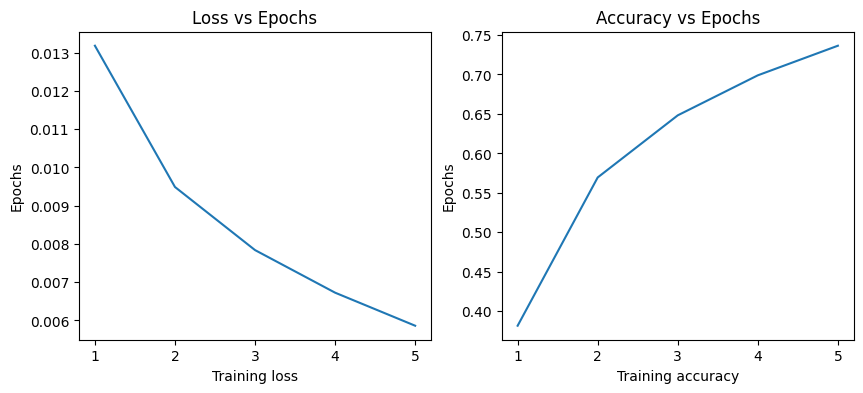

In [23]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(train_losses)+1),train_losses)
plt.xlabel('Training loss')
plt.ylabel('Epochs')
ax.set_title('Loss vs Epochs')
ax = fig.add_subplot(1,2, 2)
ax.plot(np.arange(1,len(train_acc)+1),train_acc)
plt.xlabel('Training accuracy')
plt.ylabel('Epochs')
ax.set_title('Accuracy vs Epochs')
plt.show()

In [ ]:
# Accuracy on test data after training
test_model(model, testloader)

## Questions
1) List some reasons why we should prefer CNN over ANN for image classification?

2) Try improving the CNN performance further by tuning the hyperparameters(epochs, optimizer, LR etc). Report the improved test accuracy.

3) What happens if you reduce the number of convolution layers to only 1?

4) Why didn't we use the Softmax activation in the last layer of CNN?


# 1.Convolutional Neural Networks (CNNs) are preferred over Artificial Neural Networks (ANNs) for image classification tasks due to several reasons:

Hierarchical Feature Learning: CNNs are designed to automatically learn hierarchical representations of features from images. They consist of multiple layers such as convolutional layers, pooling layers, and fully connected layers, which learn increasingly abstract features from raw pixel values. This hierarchical feature learning enables CNNs to capture local patterns (edges, textures) as well as global structures (objects, scenes) in images.
Translation Invariance: CNNs are inherently translation invariant due to the use of convolutional filters. The convolution operation allows the network to detect features at different spatial locations within the image. This property makes CNNs robust to small variations in object position, rotation, and scale, which are common in real-world images.
Parameter Sharing: CNNs exploit parameter sharing to reduce the number of learnable parameters. In convolutional layers, the same set of weights (filters) is applied across different spatial locations of the input image. This sharing of parameters helps in learning local patterns efficiently and makes CNNs more parameter-efficient compared to fully connected networks.
Sparse Connectivity: CNNs have sparse connectivity between layers. In convolutional layers, each neuron is connected only to a small local region of the input volume, determined by the receptive field of the convolutional filter. This sparse connectivity reduces the computational cost and memory requirements of the network while still capturing spatial dependencies effectively.
Local Receptive Fields: CNNs use local receptive fields to process spatial information. Convolutional filters scan the input image in a local neighborhood, capturing spatial patterns such as edges, corners, and textures. This local processing helps CNNs focus on relevant features while ignoring irrelevant background information.
Effective Parameterization: CNN architectures are designed to leverage the inherent structure of images. By exploiting spatial locality and parameter sharing, CNNs can effectively represent complex functions with relatively few parameters. This makes them well-suited for image classification tasks where the input data has spatial correlations and high-dimensional structure.
Pretrained Models: Pretrained CNN models, such as those trained on large-scale image datasets like ImageNet, are readily available. These pretrained models can be fine-tuned on specific image classification tasks with limited labeled data, leading to faster convergence and improved performance.

2.To improve the performance of a Convolutional Neural Network (CNN) for image classification, we can experiment with various hyperparameters such as the number of epochs, optimizer, learning rate, batch size, network architecture, etc. Here's a step-by-step guide to tuning these hyperparameters and reporting the improved test accuracy:

Data Preprocessing: Ensure that the data is properly preprocessed, including normalization, data augmentation, and appropriate data splitting into training, validation, and test sets.
Define the CNN Architecture: Define the CNN architecture, including the number of convolutional layers, pooling layers, fully connected layers, activation functions, dropout layers, etc.
Hyperparameter Tuning: Experiment with various hyperparameters to find the optimal combination that improves the performance of the CNN. Some hyperparameters to tune include:
Number of epochs: Increase or decrease the number of epochs to find the optimal training duration without overfitting.
Optimizer: Try different optimizers such as SGD, Adam, RMSprop, etc., and tune their learning rates.
Learning rate: Tune the learning rate of the optimizer to find the optimal rate for faster convergence without overshooting.
Batch size: Experiment with different batch sizes to find the optimal balance between computational efficiency and model performance.
Network architecture: Try different CNN architectures, including varying the number of layers, filter sizes, and kernel sizes.
Regularization techniques: Experiment with dropout, weight decay, batch normalization, etc., to prevent overfitting.
Data augmentation: Apply various data augmentation techniques such as rotation, translation, scaling, flipping, etc., to increase the diversity of the training data.
Early stopping: Use early stopping to prevent overfitting by monitoring the validation loss and stopping training when it starts to increase.
Train the CNN: Train the CNN using the training data and validate it using the validation data. Monitor the training and validation accuracy and loss to assess the model's performance during training.
Evaluate on Test Set: Once the training is complete, evaluate the trained CNN on the test set to report the final test accuracy.
Iterate: Iterate over the above steps, adjusting the hyperparameters and architecture based on the performance observed on the validation set, until satisfactory performance is achieved.

3.Reducing the number of convolutional layers to only 1 in a Convolutional Neural Network (CNN) can have several implications on the network's performance and its ability to learn complex features from the input images. Here's what happens when you reduce the number of convolutional layers to 1:

Decreased Feature Learning Capacity: With only one convolutional layer, the network's capacity to learn hierarchical and complex features from the input images is significantly reduced. Convolutional layers are responsible for detecting local patterns such as edges, textures, and simple shapes. Having only one layer limits the network's ability to capture diverse and abstract features from the input.
Limited Feature Hierarchies: CNNs with multiple convolutional layers are capable of learning hierarchical representations of features, where lower layers capture low-level features (e.g., edges) and higher layers capture high-level features (e.g., object parts, objects). With only one convolutional layer, the network lacks the depth required to learn such hierarchical representations, leading to less discriminative features.
Increased Sensitivity to Overfitting: A shallow CNN with only one convolutional layer is more prone to overfitting, especially when dealing with complex datasets with a large number of classes or high-dimensional input images. The limited capacity to learn diverse features may result in the network memorizing the training data rather than generalizing well to unseen data.
Reduced Model Expressiveness: CNNs with multiple convolutional layers can capture a wide range of spatial relationships and patterns present in the input images. By reducing the number of convolutional layers to 1, the model's expressiveness is limited, and it may struggle to capture complex structures and variations in the input data.
Lower Classification Accuracy: Overall, reducing the number of convolutional layers to only 1 is likely to result in lower classification accuracy compared to deeper CNN architectures with multiple convolutional layers. The network may struggle to learn meaningful representations of the input data, leading to suboptimal performance on image classification tasks.

4.In the context of image classification tasks with Convolutional Neural Networks (CNNs), the softmax activation function is typically used in the last layer when the network is used for multi-class classification. The softmax function normalizes the output scores of the network into a probability distribution over multiple classes, making it suitable for classification tasks where each input belongs to one of several mutually exclusive classes.

However, in some cases, the softmax activation function may not be explicitly used in the last layer of a CNN. Here are a few reasons why this might be the case:

Loss Function Compatibility: In many CNN architectures, especially when using popular deep learning frameworks like PyTorch or TensorFlow, the loss function used for training the network includes softmax activation implicitly. For example, in multi-class classification tasks, the categorical cross-entropy loss function is commonly used, which internally applies the softmax function to the network's output logits before computing the loss.
Stability and Numerical Precision: Applying the softmax activation function explicitly in the last layer of the network can sometimes lead to numerical instability, especially when dealing with deep networks and large output logits. By omitting the softmax activation in the last layer and directly using the logits as outputs, numerical stability can be improved during training and inference.
Flexibility in Post-processing: Omitting the softmax activation in the last layer gives flexibility in post-processing the network's outputs. For example, during inference, if probabilities are not needed or if the focus is on ranking predictions rather than obtaining calibrated probabilities, the raw logits can be used directly without applying softmax.
Specialized Architectures: In some specialized architectures or tasks, the network's output may not require softmax normalization. For example, in Siamese networks for similarity learning or in some regression tasks, the network may directly output continuous values without requiring softmax normalization.